In [63]:
#library
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
print(os.listdir("../data"))

['gender_submission.csv', 'test.csv', 'train.csv']


In [64]:
#import machine leanring lbirary
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [65]:
#read in the raw train_df
PATH = "../data"
train_df = pd.read_csv(PATH + "/train.csv")
test_df = pd.read_csv(PATH + "/test.csv")
gender_submission = pd.read_csv(PATH + "/gender_submission.csv")
print(train_df.head())
print(test_df.head())
print(gender_submission.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [66]:
#train_df processing
train_df.isnull().sum() # check the number of null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

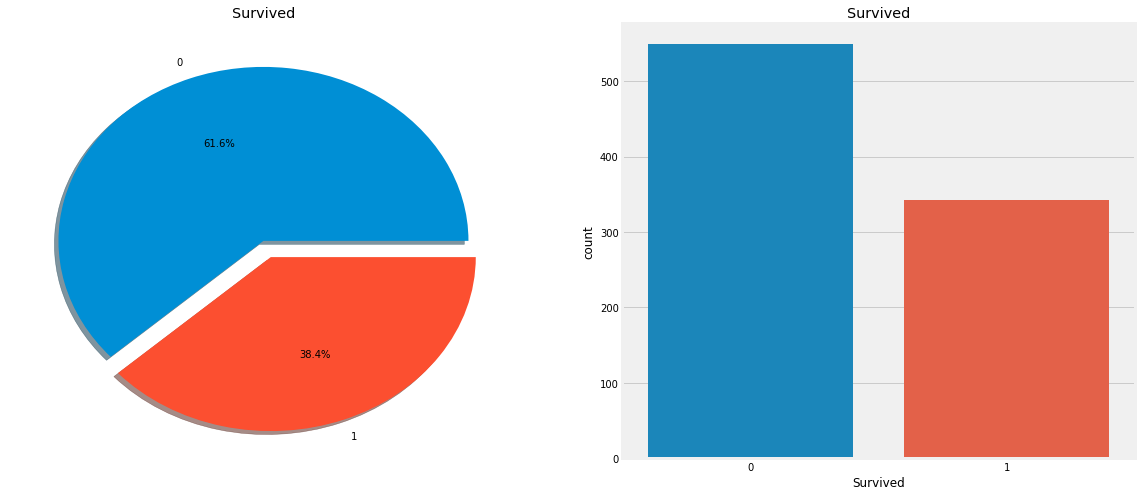

In [67]:
#dependant variable
fig,ax=plt.subplots(1,2,figsize=(18,8))
train_df['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=train_df,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

In [68]:
#feature analysis-Sex (categorical feature)
train_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

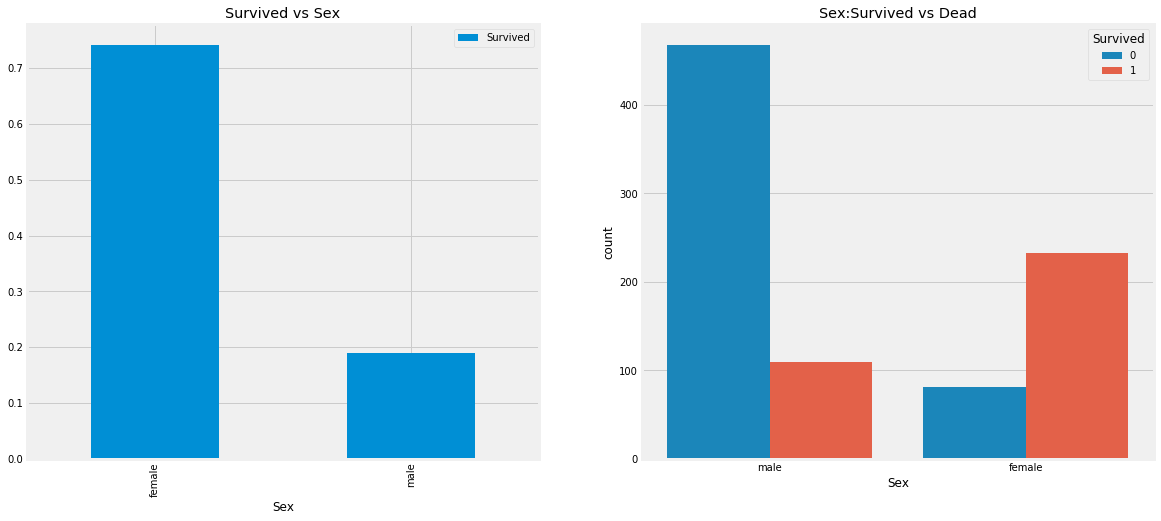

In [69]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
train_df[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex',hue='Survived',data=train_df,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

In [70]:
#feature analysis-Pclass (Ordinal feature)
pd.crosstab(train_df.Pclass,train_df.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


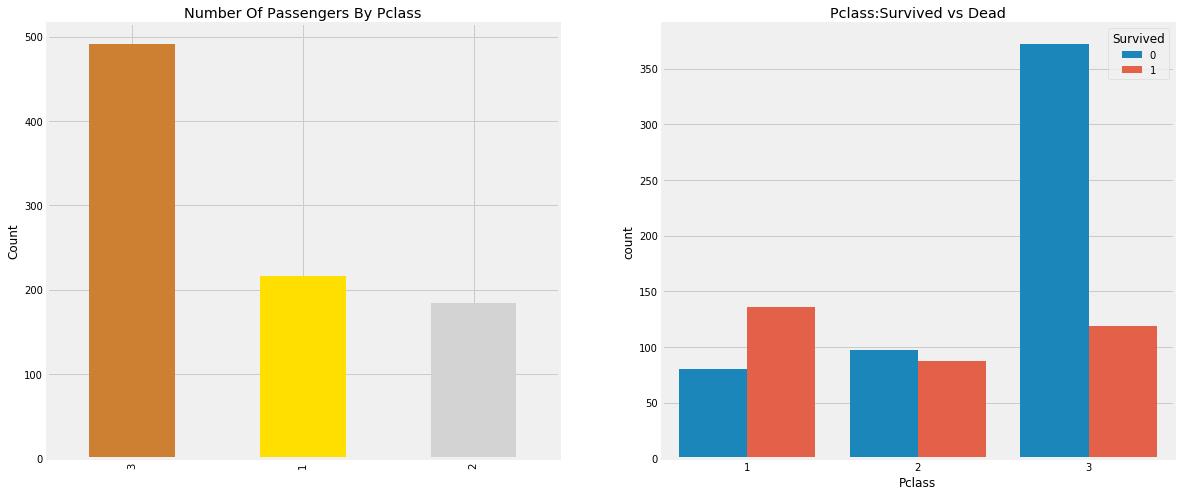

In [71]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
train_df['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=train_df,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

In [72]:
# feature analysis-Sex and Pclass together
pd.crosstab([train_df.Sex,train_df.Pclass],train_df.Survived,margins=True).style.background_gradient(cmap='summer_r')


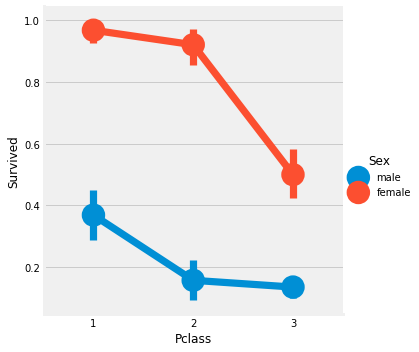

In [73]:
sns.factorplot('Pclass','Survived',hue='Sex',data=train_df)
plt.show()

In [74]:
# feature analysis-Age (Continuous feature)
print('Oldest Passenger was of:',train_df['Age'].max(),'Years')
print('Youngest Passenger was of:',train_df['Age'].min(),'Years')
print('Average Age on the ship:',train_df['Age'].mean(),'Years')


Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


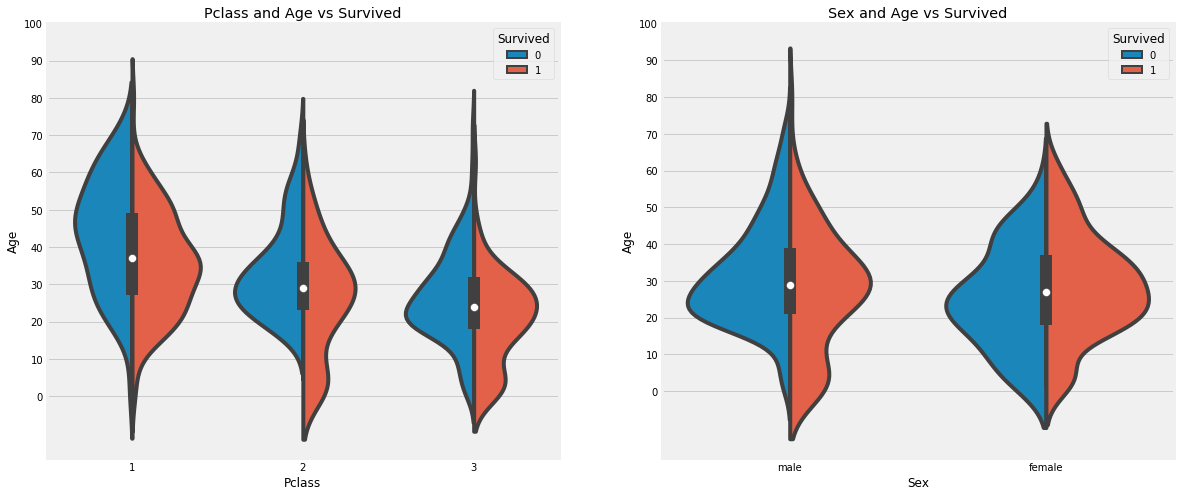

In [75]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=train_df,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=train_df,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

In [76]:
#handle the missig value for Age
#find the Salutations and repace the NaN with the mean of age for that group
train_df['Initial']=0
for i in train_df:
    train_df['Initial']=train_df.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

pd.crosstab(train_df.Initial,train_df.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [77]:
#correct the miss-spelling and replace
train_df['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [78]:
#replace the NaN with group mean of age (ceil values of the mean)
train_df.groupby('Initial')['Age'].mean() 
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Mr'),'Age']=33
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Mrs'),'Age']=36
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Master'),'Age']=5
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Miss'),'Age']=22
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Other'),'Age']=46

In [79]:
# check if there is nay NaN value for Age 
train_df.Age.isnull().any()

False

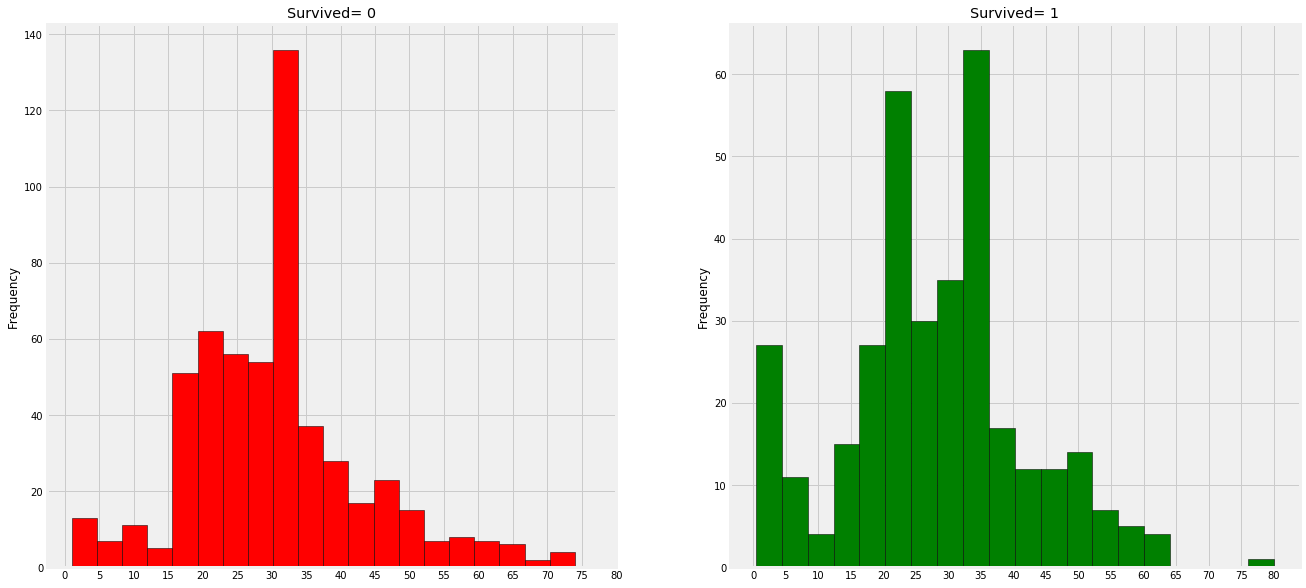

In [80]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
train_df[train_df['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train_df[train_df['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

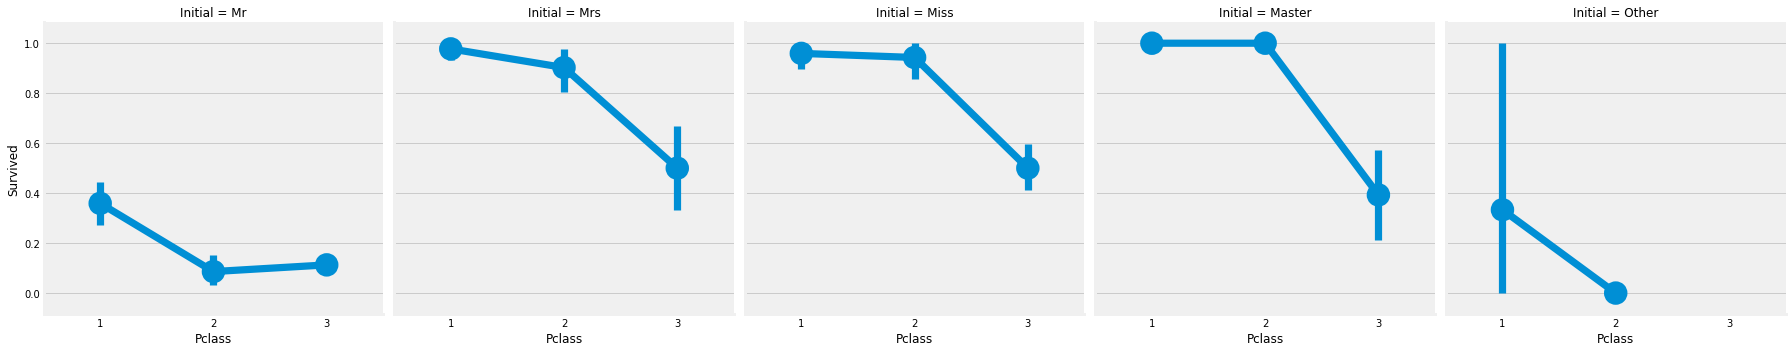

In [81]:
sns.factorplot('Pclass','Survived',col='Initial',data=train_df)
plt.show()

In [82]:
# feature analysis - Embarked (Categorical feature)
pd.crosstab([train_df.Embarked,train_df.Pclass],[train_df.Sex,train_df.Survived],margins=True).style.background_gradient(cmap='summer_r')

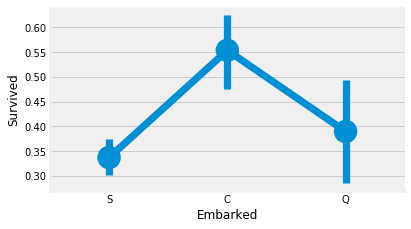

In [83]:
sns.factorplot('Embarked','Survived',data=train_df)
fig=plt.gcf()
fig.set_size_inches(6,3)
plt.show()

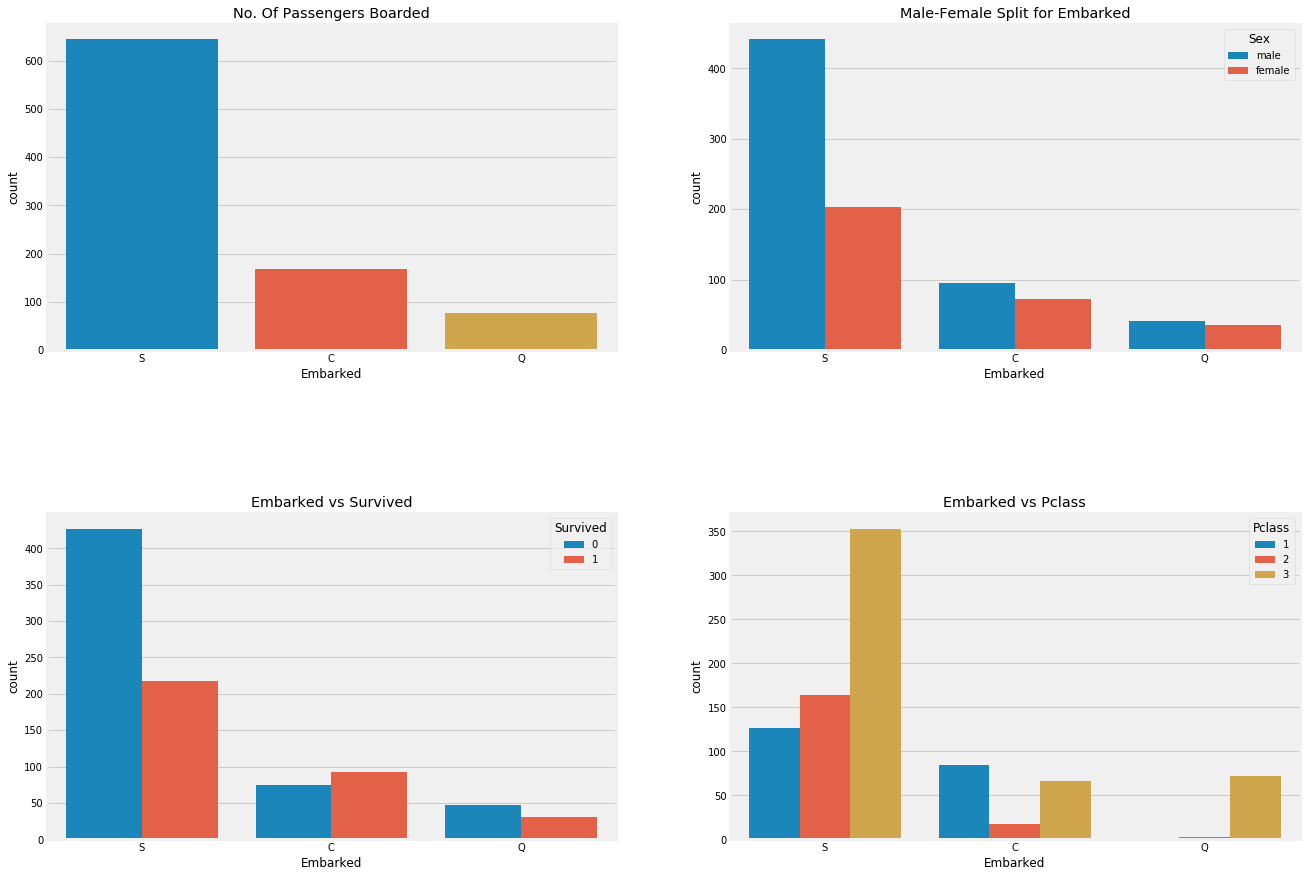

In [84]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=train_df,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=train_df,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=train_df,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=train_df,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

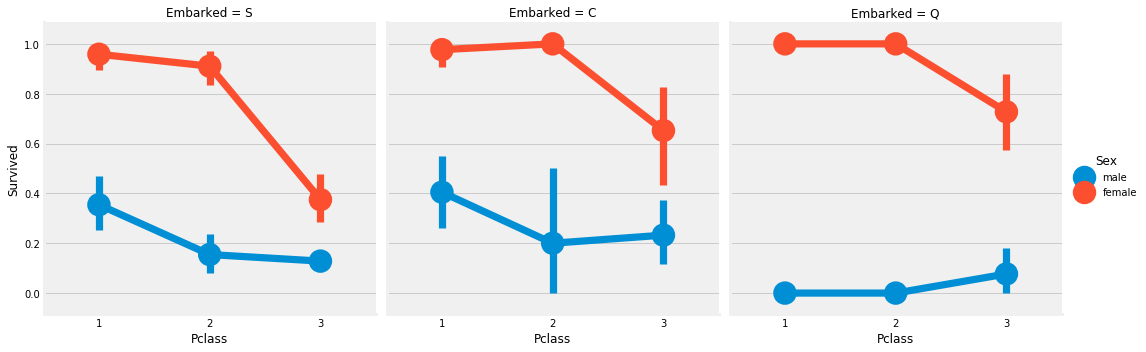

In [85]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=train_df)
plt.show()

In [86]:
#handle the missing value of Embarked
#replace with S since it's the port where most passengers boarded.
train_df['Embarked'].fillna('S',inplace=True)
train_df.Embarked.isnull().any()

False

In [87]:
# feature analysis - SibSip 
pd.crosstab([train_df.SibSp],train_df.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


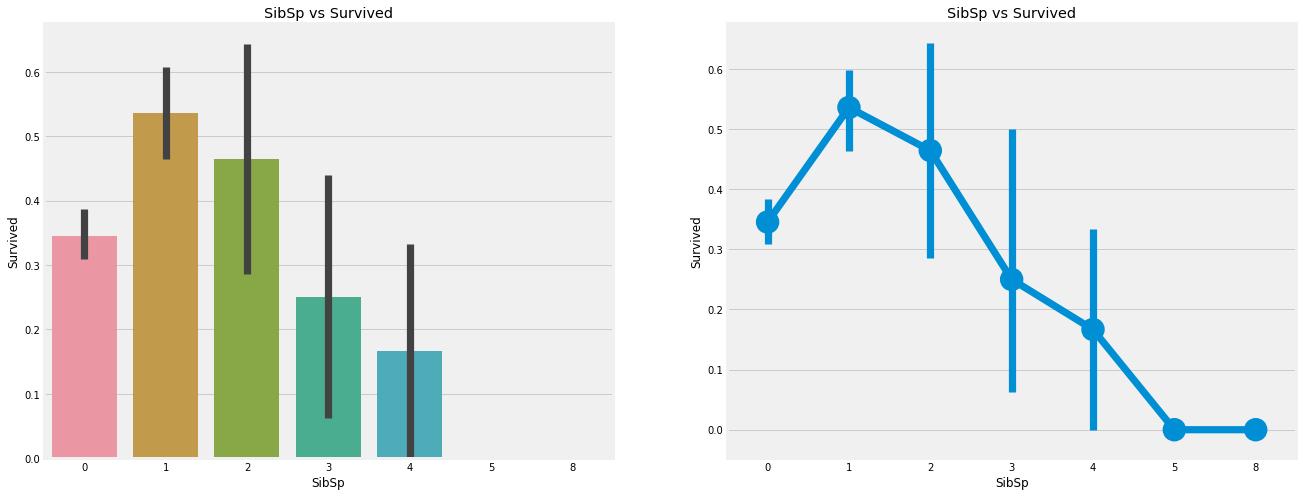

In [88]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=train_df,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=train_df,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.close(2)
plt.show()

In [89]:
pd.crosstab(train_df.SibSp,train_df.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


In [90]:
#feature analysis - Parch
pd.crosstab(train_df.Parch,train_df.Pclass).style.background_gradient(cmap='summer_r')


Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


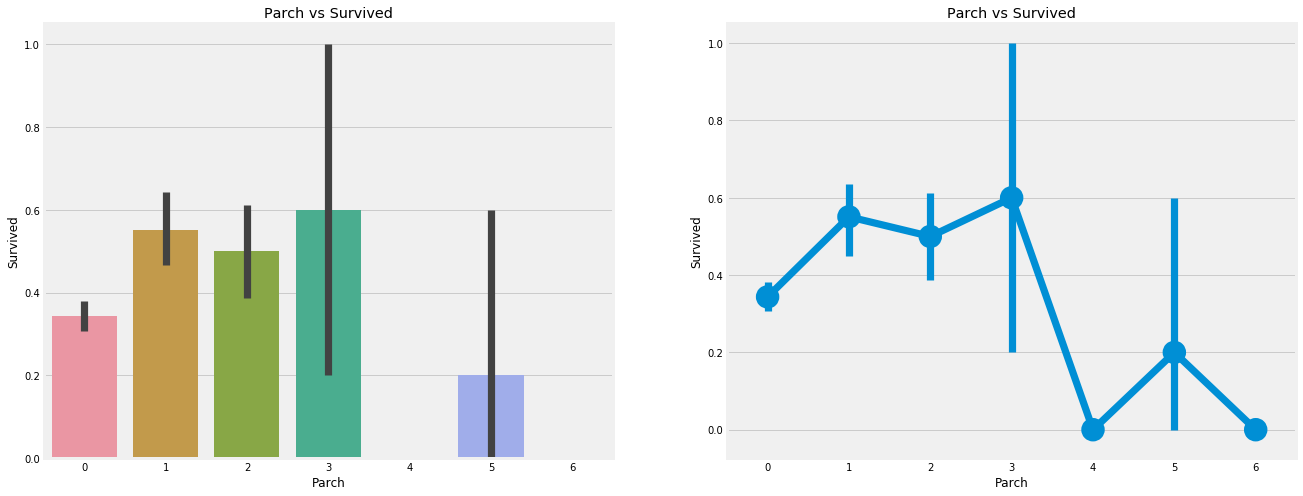

In [91]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('Parch','Survived',data=train_df,ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.factorplot('Parch','Survived',data=train_df,ax=ax[1])
ax[1].set_title('Parch vs Survived')
plt.close(2)
plt.show()

In [92]:
#feature analysis - Fare (Continuous feature)
print('Highest Fare was:',train_df['Fare'].max())
print('Lowest Fare was:',train_df['Fare'].min())
print('Average Fare was:',train_df['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


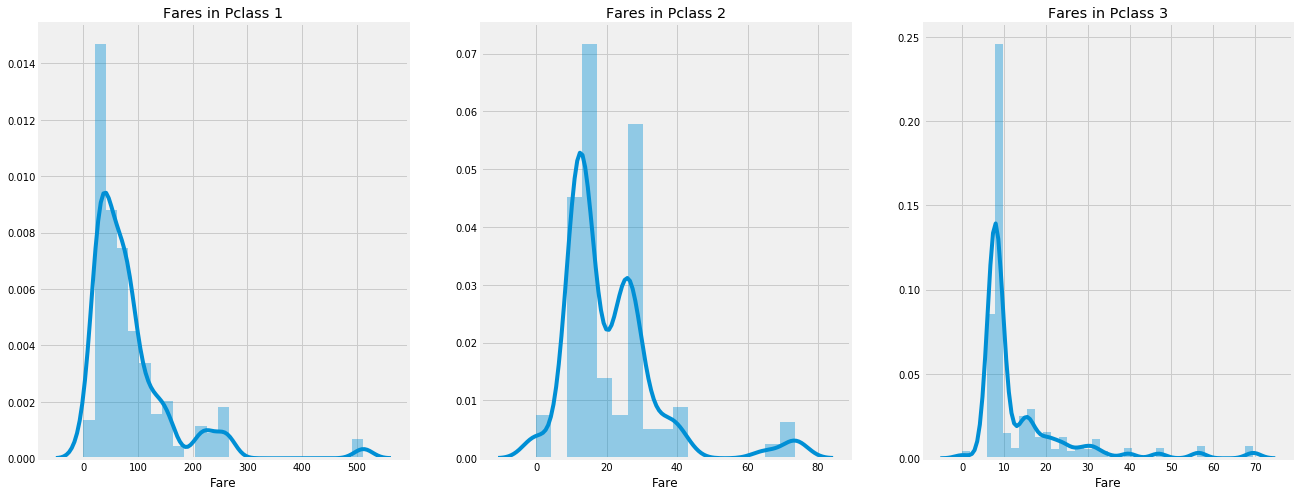

In [93]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(train_df[train_df['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(train_df[train_df['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(train_df[train_df['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

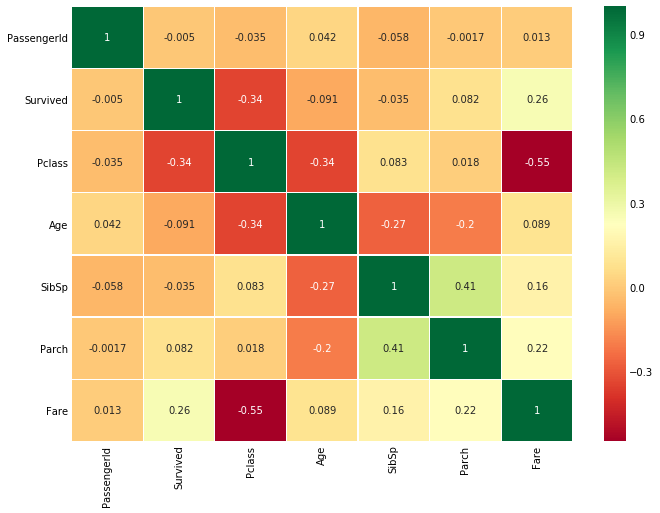

In [94]:
#correlation between features
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [95]:
#feature engineering-Convert Age to categorical variabled 
#(Max is 80,set bin number 5, width 16)
train_df['Age_band']=0
train_df.loc[train_df['Age']<=16,'Age_band']=0
train_df.loc[(train_df['Age']>16)&(train_df['Age']<=32),'Age_band']=1
train_df.loc[(train_df['Age']>32)&(train_df['Age']<=48),'Age_band']=2
train_df.loc[(train_df['Age']>48)&(train_df['Age']<=64),'Age_band']=3
train_df.loc[train_df['Age']>64,'Age_band']=4
train_df.head(2)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [96]:
train_df['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')

,Age_band
1,382
2,325
0,104
3,69
4,11


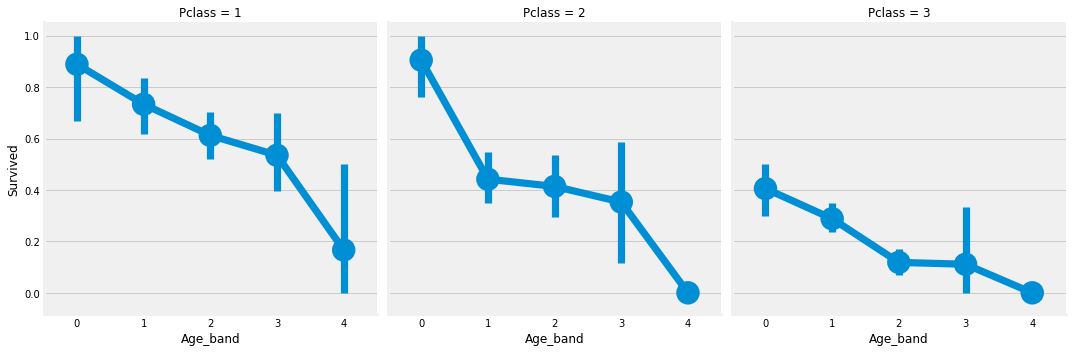

In [97]:
sns.factorplot('Age_band','Survived',data=train_df,col='Pclass')
plt.show()

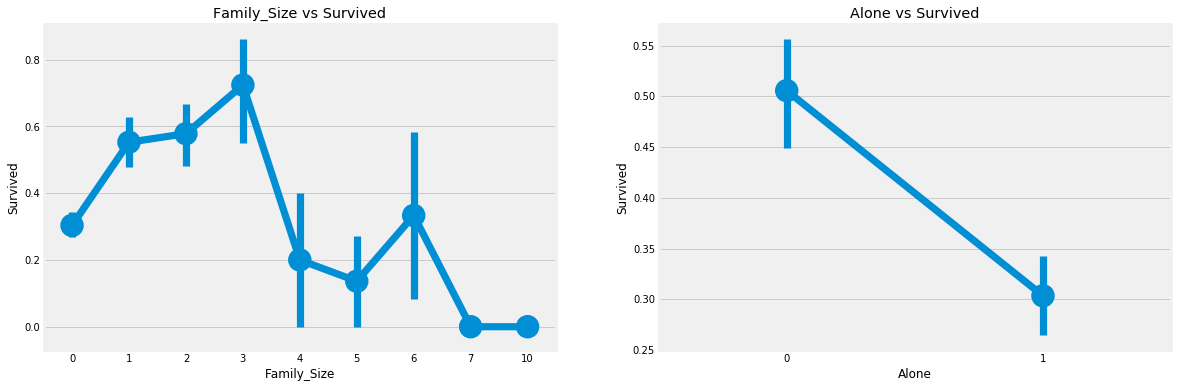

In [98]:
#feature engineering - create new variables Family_Size (sum of Parch and SibSp) 
#and Alone (= 1 if Family_size ==0 otherwise 0)
train_df['Family_Size']=0
train_df['Family_Size']=train_df['Parch']+train_df['SibSp']#family size
train_df['Alone']=0
train_df.loc[train_df.Family_Size==0,'Alone']=1#Alone

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.factorplot('Family_Size','Survived',data=train_df,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.factorplot('Alone','Survived',data=train_df,ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()


In [99]:
train_df['Family_Size'].value_counts().to_frame().style.background_gradient(cmap='summer')

,Family_Size
0,537
1,161
2,102
3,29
5,22
4,15
6,12
10,7
7,6


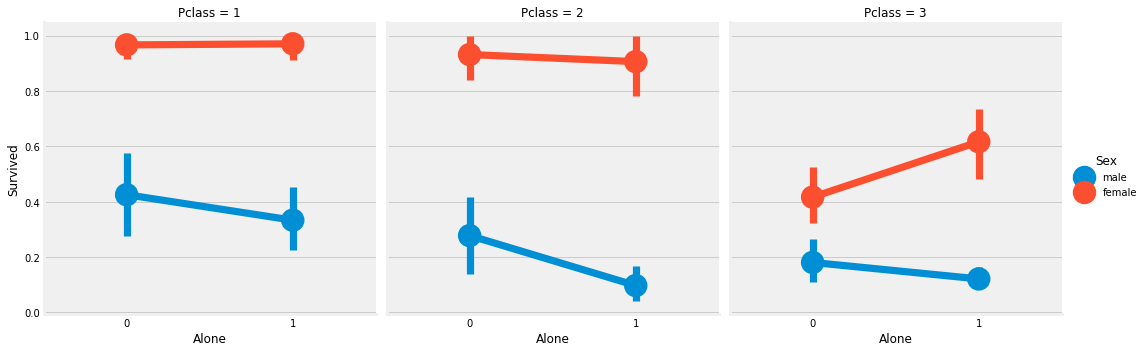

In [100]:
sns.factorplot('Alone','Survived',data=train_df,hue='Sex',col='Pclass')
plt.show()

In [101]:
#feature engineering - convert Fare to categorical feature
#first split the values to be equally space to several bins
#using the bound value to convert to categorical value
train_df['Fare_Range']=pd.qcut(train_df['Fare'],4)
train_df.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [102]:
train_df['Fare_cat']=0
train_df.loc[train_df['Fare']<=7.91,'Fare_cat']=0
train_df.loc[(train_df['Fare']>7.91)&(train_df['Fare']<=14.454),'Fare_cat']=1
train_df.loc[(train_df['Fare']>14.454)&(train_df['Fare']<=31),'Fare_cat']=2
train_df.loc[(train_df['Fare']>31)&(train_df['Fare']<=514),'Fare_cat']=3

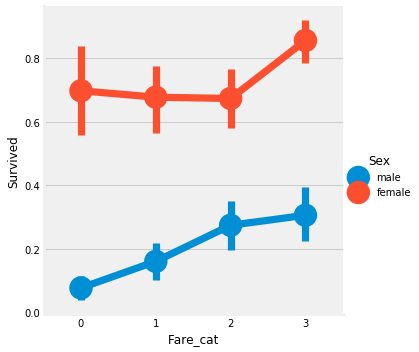

In [103]:
sns.factorplot('Fare_cat','Survived',data=train_df,hue='Sex')
plt.show()

In [104]:
#feature engineering - convert string values to numeric
train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
train_df['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
train_df['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

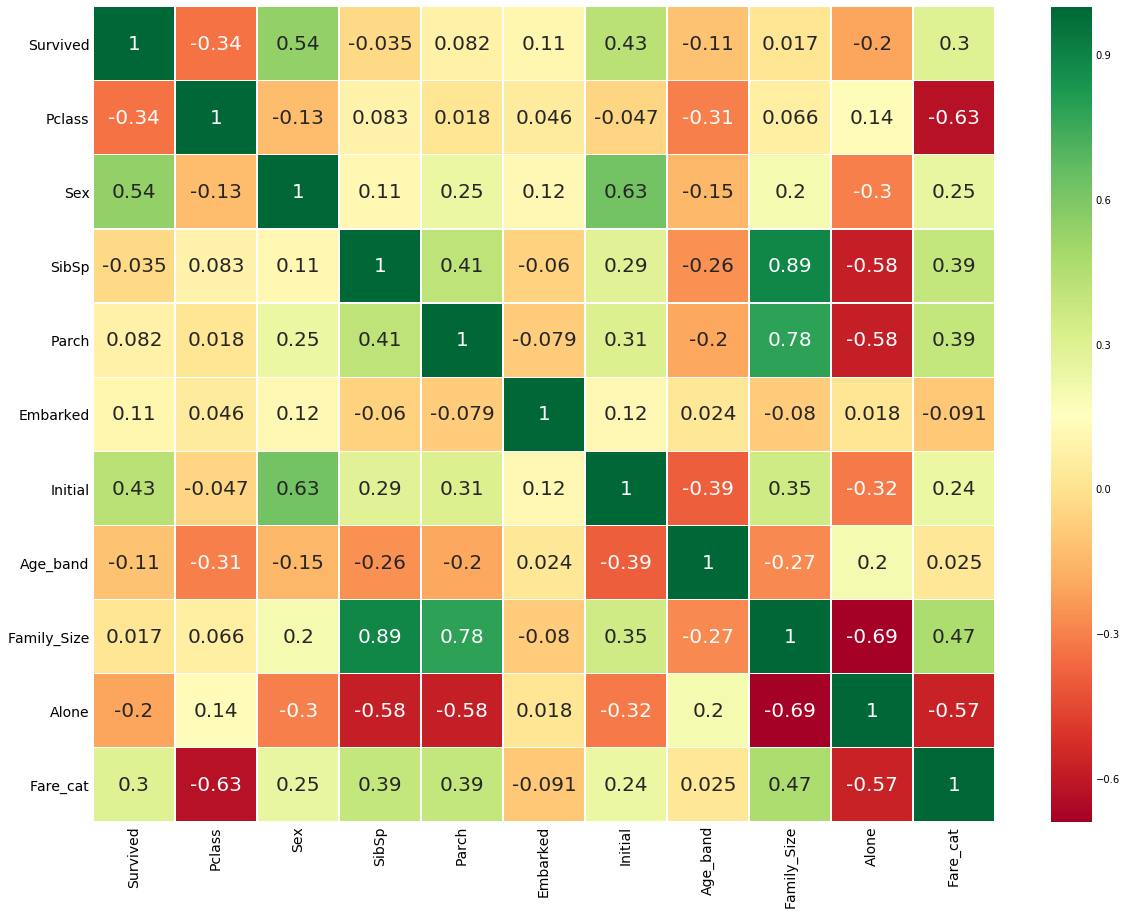

In [105]:
#feature engineering -drop unused features
train_df.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [106]:
#modeling

In [107]:
train,test=train_test_split(train_df,test_size=0.3,random_state=0,stratify=train_df['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=train_df[train_df.columns[1:]]
Y=train_df['Survived']

In [108]:
#Radial Support Vector Machines(rbf-SVM)
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.835820895522388


In [109]:
#Linear Support Vector Machine(linear-SVM)
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.8171641791044776


In [110]:
#Logtistic regression
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.8171641791044776


In [111]:
#Decision Tree
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.8022388059701493


In [112]:
#K-Nearest Neighbours (KNN)
model=KNeighborsClassifier() 
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.832089552238806


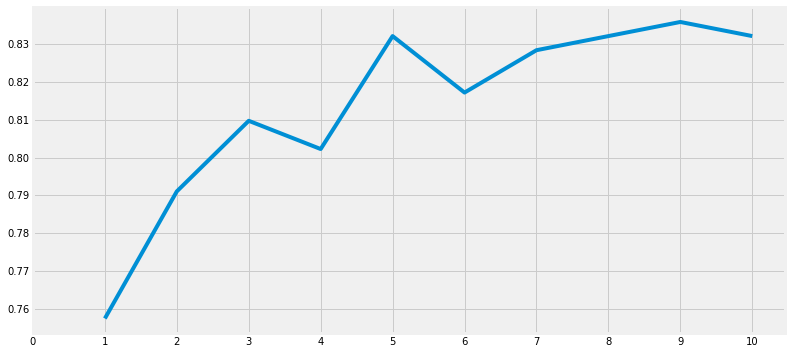

Accuracies for different values of n are: [0.75746269 0.79104478 0.80970149 0.80223881 0.83208955 0.81716418
 0.82835821 0.83208955 0.8358209  0.83208955] with the max value as  0.835820895522388


In [113]:
#Try a bounch of values for the prameter n_neighbours
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

In [114]:
#Gaussian Naive Bayes
model=GaussianNB()
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


In [115]:
#Random Forests
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forests is 0.8171641791044776


In [116]:
#Cross Validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.793471,0.047797
Radial Svm,0.828290,0.034427
Logistic Regression,0.805843,0.021861
KNN,0.813783,0.041210
Decision Tree,0.806966,0.026426
Naive Bayes,0.801386,0.028999
Random Forest,0.814869,0.039955


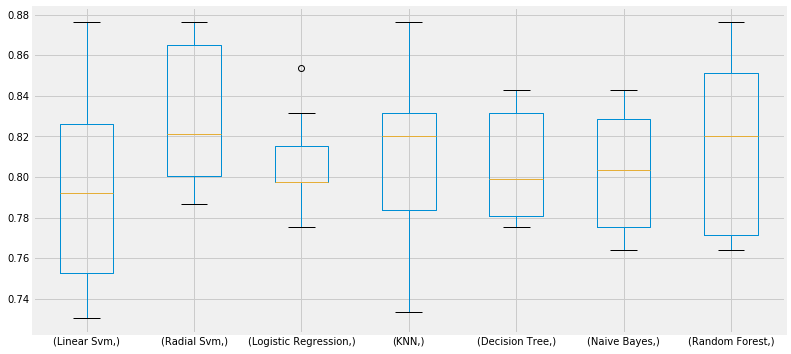

In [117]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

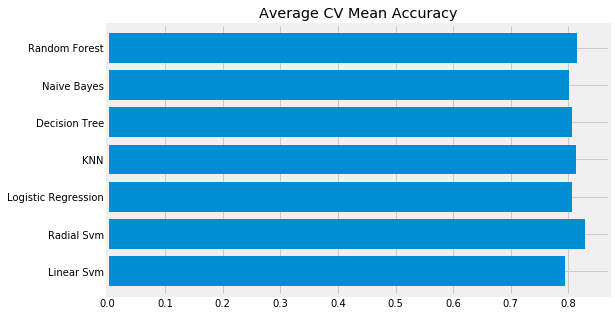

In [118]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

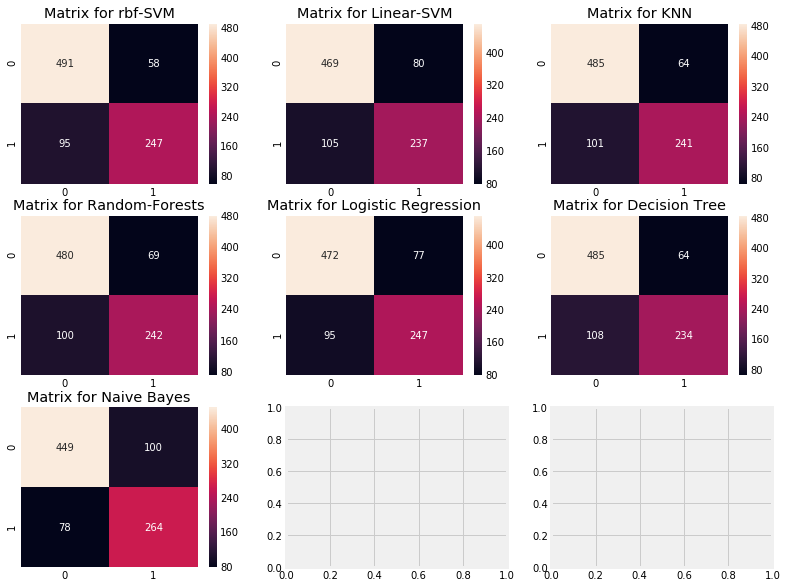

In [119]:
#Confusion Matrix
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

In [120]:
#Hyper-parameters tuning for SVM
from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8282828282828283
SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   12.9s finished


In [121]:
#hyper-parameter tuning for Randome Forests
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   16.0s finished


0.8170594837261503
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [122]:
#Ensemblling
#Voting Classifier
from sklearn.ensemble import VotingClassifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(train_X,train_Y)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(test_X,test_Y))
cross=cross_val_score(ensemble_lin_rbf,X,Y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is: 0.8246268656716418
The cross validated score is 0.8226549199863806


In [123]:
#Bagging_Knn
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged KNN is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.835820895522388
The cross validated score for bagged KNN is: 0.8148893428668709


In [124]:
#Bagging-Decision Tree
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.8246268656716418
The cross validated score for bagged Decision Tree is: 0.8204826353421859


In [125]:
#Boosting
#AdaBoosting
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())


The cross validated score for AdaBoost is: 0.8249526160481218


In [126]:
#Stochastic Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.8182862331176939


In [132]:
#rename the train data set format
train = train_df
target = 'Survived'


In [147]:
###Tuning parameters of GBM models
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Survived'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Survived'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Survived'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Survived'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')



Model Report
Accuracy : 0.8563
AUC Score (Train): 0.921074
CV Score : Mean - 0.8827574 | Std - 0.03312584 | Min - 0.8495389 | Max - 0.9342957


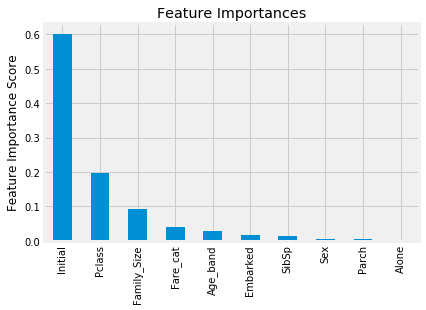

In [148]:
#Choose all predictors except target 
predictors = [x for x in train.columns if x not in [target]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

In [149]:
# 1.tune the optimal number of trees
# if the number of trees is around 20, change the learning rate to 0.05 
# if the number of trees is ~ 100, try a higher learningn rate
# use the following tree specifi parameters temporarily
# min_samples_split = 9 (~0.5-1% of total values)
# min_samples_leaf = 10 (intuition)
# max_depth = 5
# max_features = ‘sqrt’
# subsample = 0.8
predictors = [x for x in train.columns if x not in [target]]
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=9,min_samples_leaf=10,max_depth=5,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [152]:
#check output
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.03000102, 0.04179955, 0.05560722, 0.06779838, 0.08160849,
         0.09101753, 0.10120249]),
  'std_fit_time': array([0.00447357, 0.00342808, 0.00300501, 0.00305447, 0.00719182,
         0.00576645, 0.00851773]),
  'mean_score_time': array([0.00240088, 0.00239897, 0.00239987, 0.00281153, 0.00240283,
         0.00278664, 0.00259776]),
  'std_score_time': array([0.00049047, 0.00048911, 0.00048817, 0.00038642, 0.00047516,
         0.00039701, 0.00078747]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'split0_test_score': array([0.86218709, 0.85862978, 0.85019763, 0.84953887, 0.8516469 ,
         0.8544137 , 0.85032938]),
  'spl

In [158]:
#2.Tuning tree-specific parameters- tune max_depth
# using the optimal tree number 70
# firt tune the high impact parameters, such as max_depth and min_sample_split
# the optimal max_depth is 3
param_test2 = {'max_depth':range(2,10,1), 'min_samples_split':range(4,15,2)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.05999393, 0.06259875, 0.05839438, 0.05299945, 0.05399904,
         0.05119705, 0.06159954, 0.05779867, 0.06160107, 0.06200628,
         0.05841222, 0.06119466, 0.08439846, 0.08119874, 0.08059864,
         0.0771987 , 0.07819991, 0.0772017 , 0.10639791, 0.10500073,
         0.09822788, 0.10078726, 0.09760637, 0.09439964, 0.15020728,
         0.13979959, 0.13678565, 0.13320532, 0.13240581, 0.12780566,
         0.2119977 , 0.18680549, 0.17699547, 0.16361399, 0.15860972,
         0.15958877, 0.32999902, 0.28779855, 0.25260191, 0.18999872,
         0.18201303, 0.17199025, 0.41599312, 0.33001218, 0.30339966,
         0.21899266, 0.19299407, 0.17581158]),
  'std_fit_time': array([0.00155254, 0.00492506, 0.00686516, 0.0066025 , 0.00404803,
         0.00555916, 0.00605219, 0.00365557, 0.0029405 , 0.00365446,
         0.00546025, 0.00406627, 0.00272656, 0.00416503, 0.00640379,
         0.00523172, 0.00730484, 0.00886501, 0.00572647, 0.00534225,
         0.00299735, 0.

In [160]:
#Tuning tree-specific parameters - tune min_samples_split and min_samples_leaf

param_test3 = {'min_samples_split':range(4,15,2), 'min_samples_leaf':range(1,10,1)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=3,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([0.06819749, 0.067592  , 0.06939869, 0.06440144, 0.06780272,
         0.06600561, 0.06340013, 0.06759834, 0.05920267, 0.06199603,
         0.05960455, 0.06099873, 0.06600013, 0.06619925, 0.06260529,
         0.05920067, 0.06459236, 0.0598083 , 0.06560678, 0.06121025,
         0.06279445, 0.06040001, 0.0562006 , 0.05780225, 0.05941124,
         0.05840349, 0.06279335, 0.05819492, 0.06500101, 0.06239352,
         0.05776963, 0.06059408, 0.05780883, 0.0592001 , 0.0629847 ,
         0.06038342, 0.06239715, 0.05719738, 0.05799999, 0.06100616,
         0.06059446, 0.05900049, 0.06160874, 0.06241279, 0.06000872,
         0.0594027 , 0.06840672, 0.06579623, 0.0692081 , 0.06480036,
         0.06438804, 0.06599708, 0.0670083 , 0.05659699]),
  'std_fit_time': array([0.00471058, 0.0038293 , 0.00382794, 0.00637597, 0.00696861,
         0.00372608, 0.00343941, 0.00578244, 0.0022274 , 0.00089306,
         0.00243667, 0.00490199, 0.0050999 , 0.00574159, 0.00306025,
         0.


Model Report
Accuracy : 0.8395
AUC Score (Train): 0.907386
CV Score : Mean - 0.8838895 | Std - 0.02798056 | Min - 0.8485507 | Max - 0.9245818


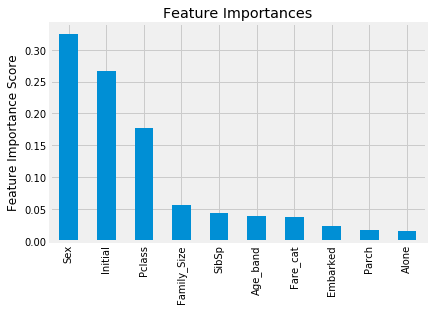

In [161]:
modelfit(gsearch3.best_estimator_, train, predictors)

In [163]:
# tune the max features
# the optimal is 3 which is same as sqrt (sqrt(10)) which is the default.
param_test4 = {'max_features':range(1,6,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=3, min_samples_split=8, min_samples_leaf=3, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([0.061797  , 0.05880046, 0.06759753, 0.06299925, 0.06299591]),
  'std_fit_time': array([0.00132865, 0.00232199, 0.00462885, 0.00384695, 0.00558406]),
  'mean_score_time': array([0.00259981, 0.00240045, 0.00179982, 0.00199924, 0.00200024]),
  'std_score_time': array([0.00080078, 0.00049014, 0.00039995, 0.00063226, 0.00063279]),
  'param_max_features': masked_array(data=[1, 2, 3, 4, 5],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 1},
   {'max_features': 2},
   {'max_features': 3},
   {'max_features': 4},
   {'max_features': 5}],
  'split0_test_score': array([0.85217391, 0.85968379, 0.85968379, 0.85731225, 0.86310935]),
  'split1_test_score': array([0.84499341, 0.84571805, 0.84855072, 0.84380764, 0.84301713]),
  'split2_test_score': array([0.88983957, 0.89451872, 0.90441176, 0.9       , 0.90093583]),
  'split3_test_score': array([0.88823529, 0.86938503, 0.88221925, 0.8

In [167]:
#3.Tuning subsample and making models with lower learning rate
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=3,min_samples_split=8, min_samples_leaf=3, subsample=0.8, random_state=10,max_features=3),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([0.06819792, 0.0701992 , 0.07419949, 0.06720047, 0.06579895,
         0.0510015 ]),
  'std_fit_time': array([0.00549261, 0.00515545, 0.00604691, 0.00890839, 0.01210838,
         0.00725655]),
  'mean_score_time': array([0.00260057, 0.00219908, 0.00219936, 0.00220017, 0.00239968,
         0.00241652]),
  'std_score_time': array([0.00049068, 0.00040119, 0.00074777, 0.0004004 , 0.00048998,
         0.00048896]),
  'param_subsample': masked_array(data=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.6},
   {'subsample': 0.7},
   {'subsample': 0.75},
   {'subsample': 0.8},
   {'subsample': 0.85},
   {'subsample': 0.9}],
  'split0_test_score': array([0.86903821, 0.86073781, 0.86047431, 0.85968379, 0.85507246,
         0.85823452]),
  'split1_test_score': array([0.84367589, 0.84644269, 0.84617918, 0.84855072, 0.84538867,
         0.848023


Model Report
Accuracy : 0.8395
AUC Score (Train): 0.907386
CV Score : Mean - 0.8838895 | Std - 0.02798056 | Min - 0.8485507 | Max - 0.9245818


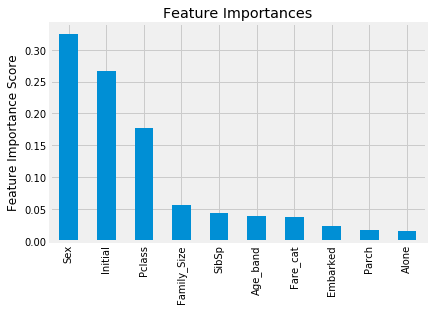

In [177]:
#Try half learning rate-No improvement
predictors = [x for x in train.columns if x not in [target]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=3,min_samples_split=8, min_samples_leaf=3, subsample=0.8, random_state=10,max_features=3)
modelfit(gbm_tuned_1, train, predictors)

In [127]:
#XGBoost
import xgboost as xg
xgboost=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

The cross validated score for XGBoost is: 0.8104710021563954


In [128]:
#Hyper-parameter tuning for AdaBoost
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  4.0min finished


0.8316498316498316
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.05, n_estimators=200, random_state=None)


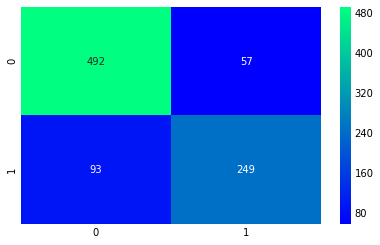

In [129]:
#confusion matrix for AdaBoost
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.05)
result=cross_val_predict(ada,X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

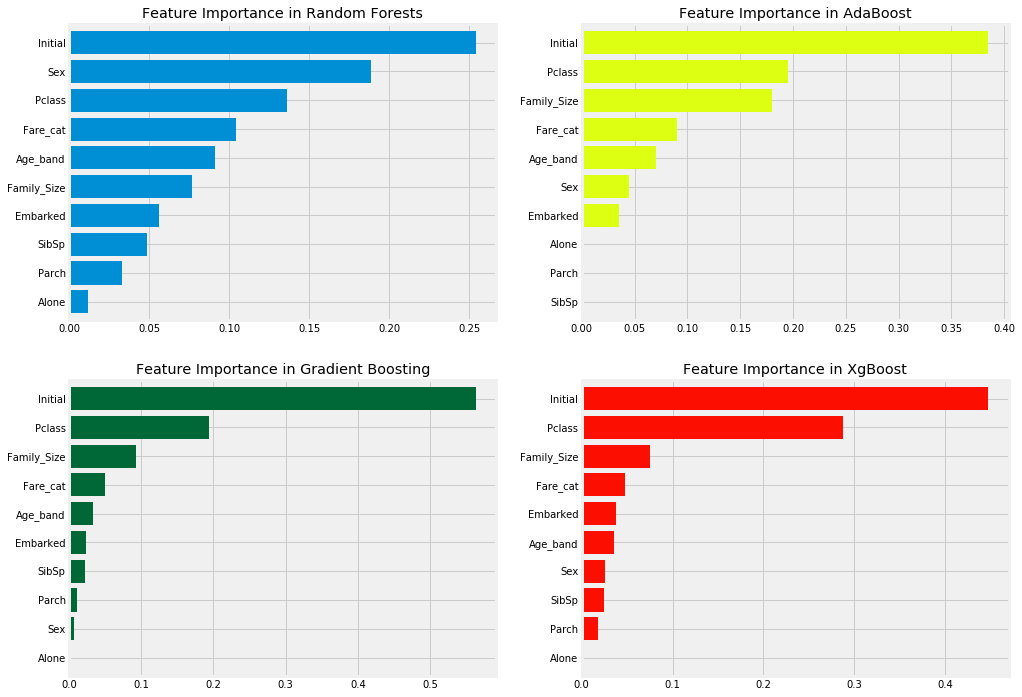

In [130]:
#feature importance
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()